# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

![SVHN overview image](svhn_examples.jpg)

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# To accelerate the training speed, the model should be run locally with GPUs
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
# Run this cell to load the dataset
train = loadmat('../../coursera_data/data/train_32x32.mat')
test = loadmat('../../coursera_data/data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Extract the training and testing images and labels separately from the train and test dictionaries

X_train=train['X'] /255
X_train=np.moveaxis(X_train,-1,0)
y_train=train['y']

y_train[y_train == 10] = 0 # change label '10' to '0', it produces errors otherwise.

X_test=test['X'] /255
X_test=np.moveaxis(X_test,-1,0)
y_test=test['y']
y_test[y_test == 10] = 0 # change label '10' to '0', it produces errors otherwise.

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (73257, 32, 32, 3)
y_train shape:  (73257, 1)
X_test shape:  (26032, 32, 32, 3)
y_test shape:  (26032, 1)


In [5]:
type(X_train)

numpy.ndarray

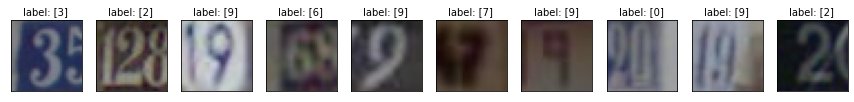

In [12]:
fig, axes=plt.subplots(1,10, figsize=(15,80))

total_image_num = X_train.shape[0]
random_inx = np.random.choice(total_image_num, 10) # 10 random number out of random_image_num
random_images = X_train[random_inx, ...]
random_labels = y_train[random_inx, ...]

for i, label in enumerate(random_labels):
    axes[i].imshow(random_images[i, ...])
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].text(5, -3, f'label: {label}')
plt.show()

In [13]:
X_train_gray=np.mean(X_train, axis=-1, keepdims=True)
X_test_gray=np.mean(X_test, axis=-1, keepdims=True)

print("X_train_gray shape: ", X_train_gray.shape)
print("y_train shape: ", y_train.shape)
print("X_test_gray shape: ", X_test_gray.shape)
print("y_test shape: ", y_test.shape)

X_train_gray shape:  (73257, 32, 32, 1)
y_train shape:  (73257, 1)
X_test_gray shape:  (26032, 32, 32, 1)
y_test shape:  (26032, 1)


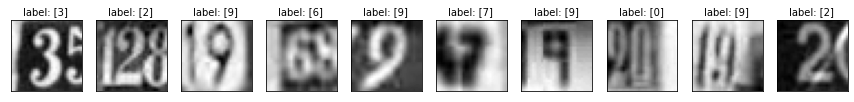

In [14]:
random_images_gray = X_train_gray[random_inx, ...]

fig, axes=plt.subplots(1,10, figsize=(15,80))

for i, label in enumerate(random_labels):
    axes[i].imshow(np.squeeze(random_images_gray[i, ...]), cmap='gray') # np.squeeze removes axes of length 1 
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].text(5, -3, f'label: {label}')

plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def my_model(input_shape):
    model=Sequential([
        Dense(512, activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')      
    ])
    return model

model=my_model(X_train_gray[0, ...].shape)

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32, 32, 512)       1024      
_________________________________________________________________
flatten_3 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               67108992  
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 67,118,922
Trainable params: 67,118,922
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Callback 1: training callback
class TrainingCallback(Callback):   
    def on_train_begin(self, logs=None):
        print("Starting training ....")
    def on_train_end(self, logs=None):
        print("Finished training!")

# Callback 2: checkpoint callback
checkpoint_path= 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only = True, verbose=1)

# Callback 3: early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)

In [30]:
history_mlp = model.fit(x=X_train_gray, y=y_train, epochs=30,validation_split=0.25, 
          batch_size=32, callbacks=[TrainingCallback(), checkpoint, early_stopping])

Starting training ....
Epoch 1/30
1716/1717 [============================>.] - ETA: 0s - loss: 1.7440 - accuracy: 0.4055
Epoch 00001: val_loss improved from inf to 1.27294, saving model to model_checkpoints/checkpoint
1717/1717 [==============================] - 22s 13ms/step - loss: 1.7437 - accuracy: 0.4056 - val_loss: 1.2729 - val_accuracy: 0.5987
Epoch 2/30
1716/1717 [============================>.] - ETA: 0s - loss: 1.1828 - accuracy: 0.6293
Epoch 00002: val_loss improved from 1.27294 to 1.09484, saving model to model_checkpoints/checkpoint
1717/1717 [==============================] - 22s 13ms/step - loss: 1.1827 - accuracy: 0.6293 - val_loss: 1.0948 - val_accuracy: 0.6590
Epoch 3/30
1716/1717 [============================>.] - ETA: 0s - loss: 1.0586 - accuracy: 0.6737
Epoch 00003: val_loss improved from 1.09484 to 1.05230, saving model to model_checkpoints/checkpoint
1717/1717 [==============================] - 22s 13ms/step - loss: 1.0591 - accuracy: 0.6736 - val_loss: 1.0523 - 

Text(0, 0.5, 'Accuracy')

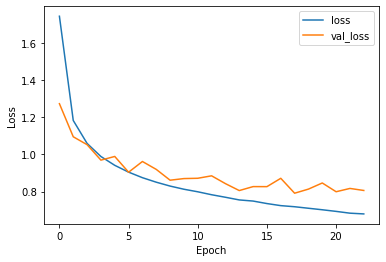

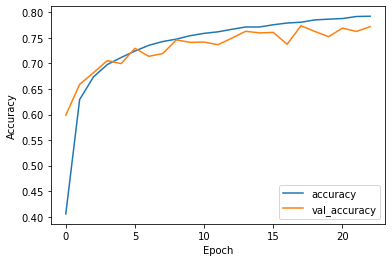

In [31]:
import pandas as pd
df_mlp = pd.DataFrame(history_mlp.history)
ax1 = df_mlp.plot(y=['loss','val_loss'])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2 = df_mlp.plot(y=['accuracy','val_accuracy'])
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")

In [32]:
loss_mlp, acc_mlp = model.evaluate(X_test_gray, y_test, verbose=0)
print('MLP model loss : {:.2f}'.format(loss_mlp))
print('MLP model accuracy : {:.2f}%'.format(100*acc_mlp))

MLP model loss : 0.98
MLP model accuracy : 74.00%


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [33]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [34]:
def cnn_model(input_shape, dr_rate):
    model = Sequential([
        Conv2D(filters=32, input_shape=input_shape, kernel_size=(3,3), activation = 'relu'),
        Dropout(dr_rate),
        Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
        Dropout(dr_rate),
        Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
        Dropout(dr_rate),
        MaxPooling2D(pool_size=(4,4)),
        BatchNormalization(),
        Flatten(),
        Dropout(dr_rate),
        Dense(units=32, activation='relu'),
        Dense(units=10, activation='softmax')
    ])
    return model

model_cnn = cnn_model(X_train_gray[0, ...].shape, 0.3)

In [17]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 8)         1160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 8)          

In [35]:
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Callback 2-2: checkpoint callback for cnn model
checkpoint_path2 = 'model_checkpoint/checkpoint2'
checkpoint2 = ModelCheckpoint(filepath = checkpoint_path2, save_weights_only = True, save_best_only = True, verbose=1)

In [37]:
history_cnn = model_cnn.fit(x=X_train_gray, y=y_train, epochs=30, validation_split=0.25, 
          batch_size=32, callbacks=[TrainingCallback(), checkpoint2, early_stopping])

Starting training ....
Epoch 1/30
1717/1717 [==============================] - ETA: 0s - loss: 1.6495 - accuracy: 0.4367
Epoch 00001: val_loss improved from inf to 1.06741, saving model to model_checkpoint/checkpoint2
1717/1717 [==============================] - 18s 11ms/step - loss: 1.6495 - accuracy: 0.4367 - val_loss: 1.0674 - val_accuracy: 0.6940
Epoch 2/30
1715/1717 [============================>.] - ETA: 0s - loss: 0.7743 - accuracy: 0.7560
Epoch 00002: val_loss improved from 1.06741 to 0.79071, saving model to model_checkpoint/checkpoint2
1717/1717 [==============================] - 8s 5ms/step - loss: 0.7742 - accuracy: 0.7560 - val_loss: 0.7907 - val_accuracy: 0.7838
Epoch 3/30
1714/1717 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.7892
Epoch 00003: val_loss improved from 0.79071 to 0.71668, saving model to model_checkpoint/checkpoint2
1717/1717 [==============================] - 8s 5ms/step - loss: 0.6662 - accuracy: 0.7893 - val_loss: 0.7167 - val_

Text(0, 0.5, 'Accuracy')

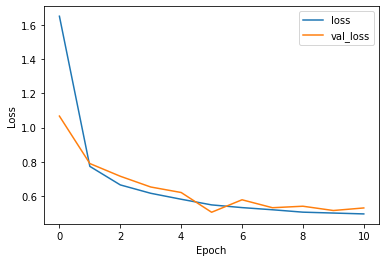

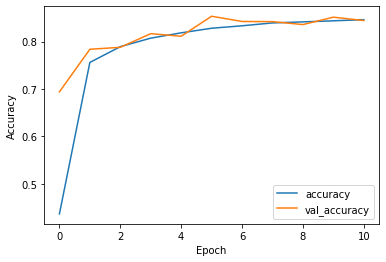

In [38]:
df_cnn = pd.DataFrame(history_cnn.history)
ax3 = df_cnn.plot(y=['loss','val_loss'])
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Loss")
ax4 = df_cnn.plot(y=['accuracy','val_accuracy'])
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Accuracy")

In [39]:
loss_cnn, acc_cnn = model_cnn.evaluate(X_test_gray, y_test, verbose=0)
print('CNN model loss : {:.2f}'.format(loss_cnn))
print('CNN model accuracy : {:.2f}%'.format(100*acc_cnn))

CNN model loss : 0.57
CNN model accuracy : 83.59%


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [40]:
# load best weights from saved mlp model
model.load_weights(checkpoint_path)

# load best weights from saved cnn model
model_cnn.load_weights(checkpoint_path2)

In [41]:
# Model predictions by MLP and CNN

num_test_images = X_test_gray.shape[0]

random_inx2 = np.random.choice(num_test_images, 5)
random_test_images = X_test_gray[random_inx2, ...]
random_test_labels = y_test[random_inx2, ...]

predictions_mlp = model.predict(random_test_images)
predictions_cnn = model_cnn.predict(random_test_images)

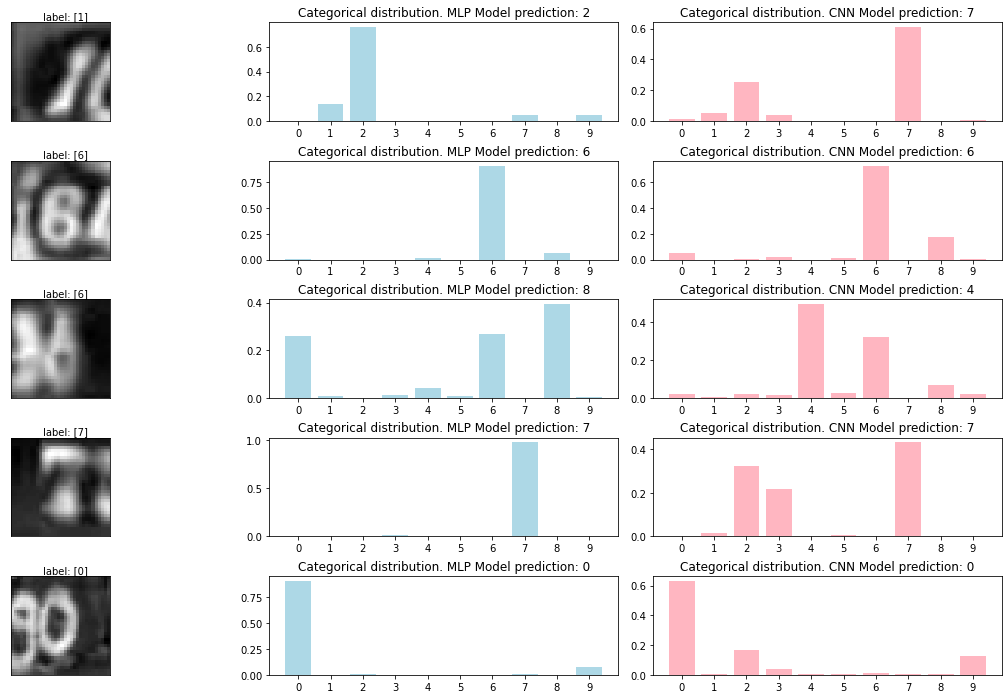

In [42]:
fig, axes = plt.subplots(5, 3, figsize=(20, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.1) 

for i, (prediction_mlp, prediction_cnn, image, label) in enumerate(zip(predictions_mlp, predictions_cnn, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image), cmap='gray')
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'label: {label}')
    axes[i, 1].bar(np.arange(len(prediction_mlp)), prediction_mlp, color='lightblue')
    axes[i, 1].set_xticks(np.arange(len(prediction_mlp)))
    axes[i, 1].set_title(f"Categorical distribution. MLP Model prediction: {np.argmax(prediction_mlp)}")
    axes[i, 2].bar(np.arange(len(prediction_cnn)), prediction_cnn, color='lightpink')
    axes[i, 2].set_xticks(np.arange(len(prediction_cnn)))
    axes[i, 2].set_title(f"Categorical distribution. CNN Model prediction: {np.argmax(prediction_cnn)}")    
    
plt.show()